# Siamese Network
Network for a Face Recognition System

# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
import collections

from IPython.display import clear_output

#Tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, MaxPooling2D, Conv2D, Dense, Dropout, Flatten
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

#Scikitlearn
from sklearn.utils import shuffle


# Dataset

## Utility Functions

In [2]:
## This function for making pairs  
## (both positive and negative pairs)
def generate_pairs(images, labels):
  # Generate label and index
  label_unique = np.unique(labels)                  # make a dictionary like this :
  label_indices = collections.defaultdict(list)     # label_indices = {
  i = 0                                             # 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  for idx, label in enumerate(labels):              # 1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    if label == i:                                  # ...
      label_indices[label].append(idx)              # }
    else:
      i += 1

  # Generate image and labels pairs
  pair_images = []
  pair_labels = []
  for idx, image in enumerate(images):
    # positive pairs
    indices = label_indices.get(labels[idx])     # indices = [11, 12, 13, 14, 15, 16, 17, 18, 19]
    positive = images[np.random.choice(indices)] # image = take random image from index above
    pair_images.append((image, positive))        # make a positive pairs
    pair_labels.append(1)                        # (+) pairs labeled with 1

    # negative pairs
    indices = np.where(labels != labels[idx])         # neg_indices = other indices from indices above 
    negative = images[np.random.choice(indices[0])]   # neg_indices[0] -> take array from list
    pair_images.append((image, negative))             # make a negative pairs
    pair_labels.append(0)                             # (-) pairs labeled with 0
      
  return np.array(pair_images), np.array(pair_labels)

In [3]:
# Get the GDrive paths
# https://drive.google.com/file/d/1RWfKbQB-OMD8bIeyM0GnqovCA3VOWZgw/view?usp=sharing
!gdown 'https://drive.google.com/uc?id=1RWfKbQB-OMD8bIeyM0GnqovCA3VOWZgw'

# Unzip the file
!unzip /content/olivetti.zip
clear_output()

## Prepare Data

In [4]:
# Get the data directory paths
images_path = '/content/olivetti_faces.npy'
labels_path = '/content/olivetti_faces_target.npy'

# Load the images and labels
face_images = np.load(images_path)
face_labels = np.load(labels_path)

# Define the target shape
target_shape = face_images[0].shape

# Make a pairs of image, set label, and shuffle the dataset
images_dataset, labels_dataset = generate_pairs(face_images, face_labels)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

## Visualize

In [5]:
def show_images(images, labels, cmap = 'gray', nrows = 10, pair = False):
  """
  images = ("face_images", "images_dataset")
  images must be an three dimensional array (n, x, y) or 
  four dimensional array (n, x, y, c) if there's 3 channel

  labels = ("face_labels", "labels_dataset")
  """
  # Count nrows
  ncols = nrows if pair else 10
  nrows = 2 if pair else nrows

  # Set the fig size
  x = ncols * 1.6
  y = nrows * 1.6
  figsize = (x, y)

  if pair:
    n = images.shape[0]
    p = images.shape[1]
    x, y = images.shape[2], images.shape[3]
    images = images.reshape(n*p, x, y)

  # Image
  fig,ax = plt.subplots(nrows, ncols,
                        figsize = figsize,
                        subplot_kw = dict(xticks=[], yticks=[]))  # remove x and y axis
  if pair:
    fig.suptitle('This is sample of {} pair faces.'.format(ncols), fontsize = 16)
    for col in range(ncols):
      for row in range(nrows):
        ax[row, col].imshow(images[col*nrows + row], cmap = cmap)   # print the images
        ax[1, col].set_xlabel(labels[col])                          # print the labels
  else:
    fig.suptitle('This is sample of {} faces of {} person.'.format(nrows*ncols, nrows),
                 fontsize = 16)
    for row in range(nrows):
      for col in range(ncols):
        ax[row, col].imshow(images[row*ncols + col], cmap = cmap)   # print the images
        ax[row, col].set_xlabel(labels[row*ncols + col])            # print the labels
  plt.show()

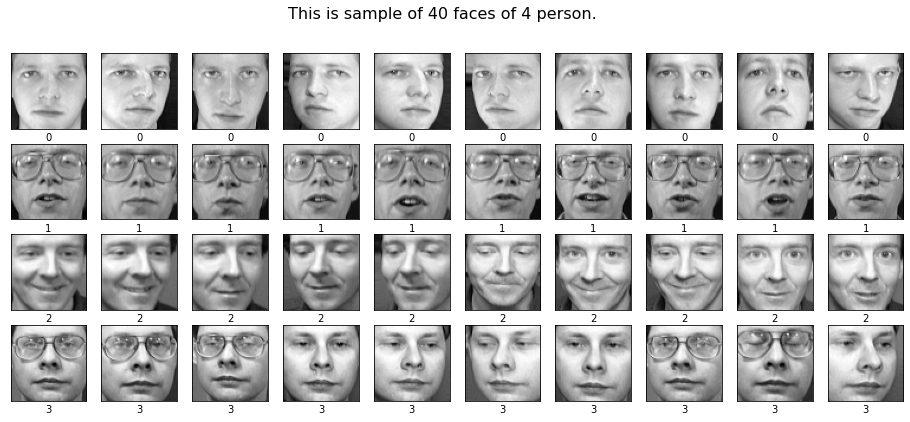

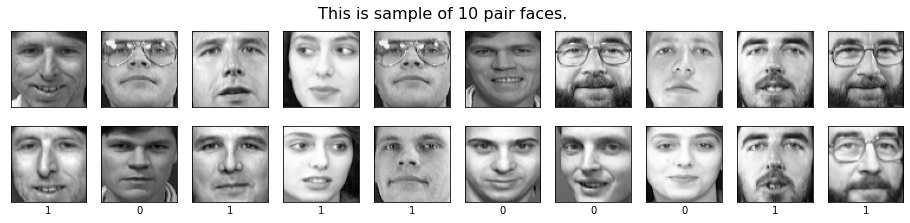

In [6]:
show_images(images = face_images, labels = face_labels, nrows = 4, pair = False)
show_images(images = images_dataset, labels = labels_dataset, nrows = 10, pair = True)

# Network Architecture

## Embedding Layer and Siamese Network


In [7]:
# Define the Contrastive Loss
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss

In [8]:
# Distance Layer
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance
    between the embeddings
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [9]:
def siamese_model(x, y, batch_size=64, dropout=0.3, metrics='accuracy', epochs=150, pool_size=2, validation_split=0.2, summary=False, callbacks=None, checkpoint=None):
 
  #Embedding layer
  embedding = Sequential([Conv2D(64, (10,10), padding="same", activation="relu",input_shape=(64, 64, 1)),
                      MaxPooling2D(pool_size=(pool_size ,pool_size)),      
                      Dropout(dropout), 
                      Conv2D(128, (7,7), padding="same", activation="relu"),
                      MaxPooling2D(pool_size=(pool_size ,pool_size)),
                      Dropout(dropout),
                      Conv2D(128, (4,4), padding="same", activation="relu"),
                      MaxPooling2D(pool_size=(pool_size ,pool_size)), 
                      Dropout(dropout),
                      Conv2D(256, (4,4), padding="same", activation="relu"),
                      Flatten(),
                      Dense(4096, activation = "relu"),
                      Dense(1024, activation = "sigmoid")
  ])

  anchor_input = Input(name="anchor", shape=target_shape + (1,))
  compare_input = Input(name="compare", shape=target_shape + (1,))

  distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),)
  
  outputs = layers.Dense(1, activation = "sigmoid") (distances)

  siamese_model = Model(inputs=[anchor_input, compare_input], 
                        outputs=outputs)
  
  
  siamese_model.compile(optimizer=Adam(), 
                loss=BinaryCrossentropy(), 
                metrics=[metrics])

  if summary:
    siamese_model.summary()
  
  history = siamese_model.fit(x=x, 
                      y=y,
                      epochs=150, 
                      validation_split = validation_split, 
                      batch_size = batch_size)
  
  #Visualizing the loss and accuracy
  visualize = (plt.plot(history.history["loss"]),
  plt.plot(history.history["val_loss"]),
  plt.plot(history.history["accuracy"]),
  plt.plot(history.history["val_accuracy"]),
  plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"]))

  
  return history, siamese_model, visualize

# Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#Optional
callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
checkpoints = ModelCheckpoint('Model' + '{accuracy:.2f}acc.h5', verbose=1) # Create Keras SavedModel as checkpoints

Epoch 1/150
10/10 [==============================] - 15s 194ms/step - loss: 0.6684 - accuracy: 0.5000 - val_loss: 0.6178 - val_accuracy: 0.5625
Epoch 2/150
10/10 [==============================] - 1s 120ms/step - loss: 0.6210 - accuracy: 0.5000 - val_loss: 0.6031 - val_accuracy: 0.5625
Epoch 3/150
10/10 [==============================] - 1s 125ms/step - loss: 0.6244 - accuracy: 0.5000 - val_loss: 0.6066 - val_accuracy: 0.5750
Epoch 4/150
10/10 [==============================] - 1s 136ms/step - loss: 0.6285 - accuracy: 0.5000 - val_loss: 0.6006 - val_accuracy: 0.5875
Epoch 5/150
10/10 [==============================] - 1s 127ms/step - loss: 0.6151 - accuracy: 0.5031 - val_loss: 0.6121 - val_accuracy: 0.5813
Epoch 6/150
10/10 [==============================] - 1s 120ms/step - loss: 0.6109 - accuracy: 0.5063 - val_loss: 0.6075 - val_accuracy: 0.5813
Epoch 7/150
10/10 [==============================] - 1s 121ms/step - loss: 0.6052 - accuracy: 0.5156 - val_loss: 0.6052 - val_accuracy: 0.631

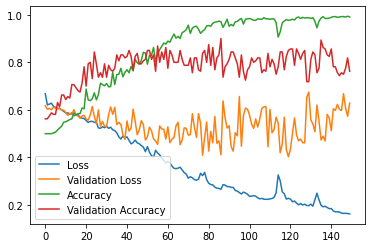

In [10]:
#Train Model and Visualize the loss and accuracy
history, siamese_model, visualize = siamese_model(x=[images_dataset[:, 0, :], images_dataset[:, 1, :]],
                                                  y=labels_dataset, epochs=150, validation_split = 0.2, batch_size = 64)

In [11]:
siamese_model.save('/content/siamese_model')

INFO:tensorflow:Assets written to: /content/siamese_model/assets


# Testing

In [12]:
def visualize_images(images, n = 5):
    #Visualize the images

    def visual(ax, image):
        ax.imshow(image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    axs = fig.subplots(1, n)
    for i in range(n):
        visual(axs[i], images[i])

In [13]:
def predict(image_pairs):
  score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])
  return print(score)

In [14]:
def pairs_test(i,n):
  #Visualizes the images and the prediction and show the prediction results
  test_index = random.sample(range(i), 1)[0]
  test_image = face_images[test_index]
  fig,ax = plt.subplots(figsize = (3,3),
                        subplot_kw = dict(xticks=[], yticks=[])) 
  ax.imshow(test_image, cmap='gray')
  compare_images = []
  for i in range(n):
      index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
      images = face_images[index]
      compare_images.append(images)
  visualize_images(compare_images)
  image_pairs = []

  for images in compare_images:
      image_pairs.append((test_image, images))
    
  image_pairs = np.array(image_pairs)
  return image_pairs


[[0.3889316 ]
 [0.00799263]
 [0.00071287]
 [0.00045126]
 [0.00041002]]


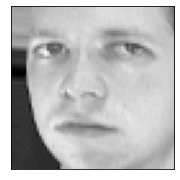

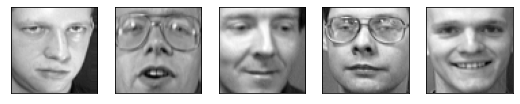

In [15]:
predict(pairs_test(10,5))